# Import Libraries

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import Subset
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set Hyperparameters

In [ ]:
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
Z_DIM                   = 512
W_DIM                   = 512
IN_CHANNELS             = 512   # IMPORTANT: set this to 512 to match stylegan2/rosinality weights
CHANNELS_IMG            = 3
RESOLUTIONS             = [8, 16, 32, 64, 128]
BATCH_SIZES             = [128, 64, 32, 16, 8]
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)
START_TRAIN_AT_IMG_SIZE = 8
LEARNING_RATE           = 5e-4
LAMBDA_GP               = 10
FACTORS                 = [512, 512, 256, 128, 64, 32, 16, 8]

# FACTORS                 = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Dataset

## Download

**Flickr-Faces-HQ (FFHQ) small**

FFHQ is an image dataset containing high-quality images of human faces. It offers 3143 (small version) PNG images at 1024×1024 resolution that display diverse ages, ethnicities, image backgrounds, and accessories like hats and eyeglasses.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

print("Path to dataset files:", path)

## DataLoader

In [ ]:
def get_data_loader(image_size, batch_size, limit=1000):

  transform = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize(
          [0.5 for _ in range(CHANNELS_IMG)],
          [0.5 for _ in range(CHANNELS_IMG)],
      ),
  ])

  train_data = datasets.ImageFolder(root=path, transform=transform)

  if limit is not None:
        indices = torch.randperm(len(train_data))[:limit]
        train_data = Subset(train_data, indices)

  train_loader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=4,
      pin_memory=True,
      persistent_workers=True
  )

  return train_loader

## Visualization

In [ ]:
t_loader = get_data_loader(512)
img = t_loader.dataset[0][0]
img.shape

In [ ]:
numpy_img = t_loader.dataset[0][0].numpy().transpose(1, 2, 0)
numpy_img.shape

In [ ]:
torch_img = img.permute(1, 2, 0)
torch_img.shape

In [ ]:
plt.figure()
plt.imshow(torch_img)
plt.show()

# Model

## Noise Mapping Network

It takes Z latent and puts it through eight fully connected layers after normalization.

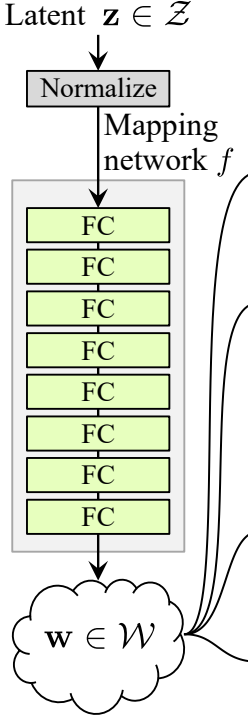

### WSLinear (weighted scaled Linear)

The goal is to stabilize training by controlling the distribution of activations in each layer. StyleGAN uses equalized learning rate (a.k.a. weight scaling) so that weights have a consistent dynamic range during training, regardless of the number of input features.

Normally, different network layers can output values with widely different variances, making optimization unstable. WSLinear fixes that by explicitly scaling the input before applying the weight matrix.


So we use:
- y = W (x * scale) + b

instead of:
- y = W x + b

---

### Why the scale is `(2 / in_features) ** 0.5`

Consider a linear layer:


- $ y = W x $

where  

- $( W \sim \mathcal{N}(0, 1) $)  (weights initialized from standard normal)  
- $( x $) has variance $( \sigma^2 $)  
- The number of inputs per neuron is $( in\_features $).  

--

### Variance of the output

The variance of the output is

$
\text{Var}[y] = \text{fan\_in} \cdot \text{Var}[W] \cdot \text{Var}[x]
$

Since $( \text{Var}[W] = 1 $) (because $( W \sim \mathcal{N}(0,1) $)):

$
\text{Var}[y] = \text{in\_features} \cdot \sigma^2
$

--

### To stabilize training

We want to keep variance stable across layers:

$
\text{Var}[y] \approx \sigma^2
$

That means we must rescale the input by a factor:

$
\text{scale} = \sqrt{\frac{2}{\text{in\_features}}}
$

--

### Final formula

So the forward pass becomes:

$
y = W \cdot (x \cdot \text{scale}) + b
$


In [ ]:
class WSLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        # Weight: initialized from N(0,1)
        self.weight = nn.Parameter(torch.randn(out_features, in_features))

        # Bias: initialized to zero
        self.bias = nn.Parameter(torch.zeros(out_features))

        # Precompute scaling factor for equalized learning rate
        self.scale = (2 / in_features) ** 0.5

    def forward(self, x):
        return F.linear(x * self.scale, self.weight, self.bias)

### MappingNetwork class

In [ ]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self, x):
        return self.mapping(x)

## AdaIN (Adaptive Instance Normalization)

AdaIN is used to inject **style information** into feature maps.  
It combines the **content features** with the **style statistics** (mean and variance) learned from the style vector.

---
### Steps

### Step 1: Instance Normalization

Given feature map $( x \in \mathbb{R}^{N \times C \times H \times W} $),  
for each channel $( c $), we normalize:

$
\text{IN}(x_{i}) = \frac{x_{i} - \mu(x_{i})}{\sigma(x_{i})}
$


This makes each feature map have zero mean and unit variance.

--

### Step 2: Adaptive Re-scaling (Style Injection)

From the **style vector** \( y \), two learnable affine transforms are applied to generate:

$
\gamma(y), \quad \beta(y)
$

where  
- $( \gamma(y) $) controls the **variance (scale)**,  
- $( \beta(y) $) controls the **mean (bias)**.  

--

### Step 3: AdaIN Formula

The final AdaIN transformation is:

$
\text{AdaIN}(x, y) = \gamma(y) \cdot \frac{x - \mu(x)}{\sigma(x)} + $



In [ ]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()

        # Instance normalization normalizes each channel independently
        self.instance_norm = nn.InstanceNorm2d(channels)

        # Map style vector w -> (scale, bias)
        self.style_scale = WSLinear(w_dim, channels)
        self.style_bias = WSLinear(w_dim, channels)

    def forward(self, x, w):
        # Normalize input features
        x = self.instance_norm(x)

        # Compute scale and bias from style vector
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)

        # Apply AdaIN: scale * normalized_x + bias
        return style_scale * x + style_bias

## Inject Noise

Inject the noise into the generator

In [ ]:
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Per-channel trainable scaling factor for noise
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))  # Use nn.Parameter so that these weights can be optimized

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

## WSConv2d

In [ ]:
class WSConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        # Weight: initialized from N(0,1)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

        # Bias: initialized to zero
        self.bias = nn.Parameter(torch.zeros(out_channels))

        # Precompute scaling factor for equalized learning rate
        self.scale = (2 / (in_channels * kernel_size ** 2)) ** 0.5

        self.stride = stride
        self.padding = padding

    def forward(self, x):
        out = F.conv2d(x * self.scale, self.weight, bias=self.bias, stride=self.stride, padding=self.padding)
        return out


## Generator

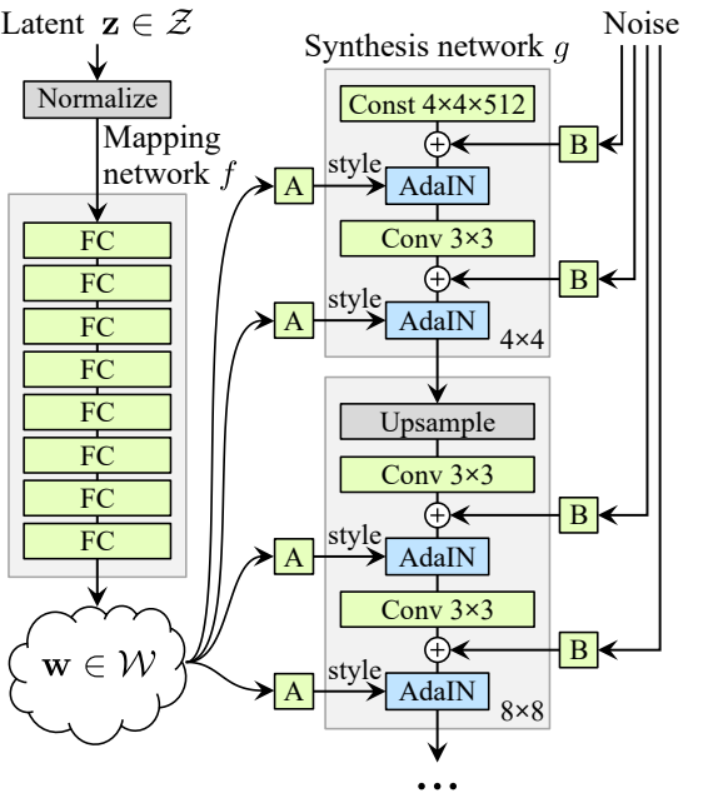

Key parts:

- starting_constant → Instead of starting from a random tensor, StyleGAN starts from a learned constant 4×4 feature map.

- MappingNetwork → Maps latent vector z to style vector w. This "disentangles" the latent space, improving controllability.

- factors → controls channel reduction as resolution grows.

- fade_in → Prevents sudden jumps when introducing higher resolutions during training.

In [ ]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = InjectNoise(out_channels)
        self.inject_noise2 = InjectNoise(out_channels)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        x = self.conv1(x)
        x = self.inject_noise1(x)
        x = self.leaky(x)
        x = self.adain1(x, w)

        x = self.conv2(x)
        x = self.inject_noise2(x)
        x = self.leaky(x)
        x = self.adain2(x, w)
        return x

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, w_dim, factors, in_channels, img_channels=3):
    super(Generator, self).__init__()

    self.starting_constant = nn.Parameter(torch.ones((1, in_channels, 4, 4)))
    self.map = MappingNetwork(z_dim, w_dim)

    # First block operates on the starting_constant
    # Initial conv + noise + AdaIN layers
    self.initial_conv = WSConv2d(in_channels, in_channels)
    self.initial_noise1 = InjectNoise(in_channels)
    self.initial_noise2 = InjectNoise(in_channels)
    self.initial_adain1 = AdaIN(in_channels, w_dim)
    self.initial_adain2 = AdaIN(in_channels, w_dim)
    self.leaky = nn.LeakyReLU(0.2, inplace=True)

    # 1×1 convs that convert feature maps into RGB images at each resolution
    self.initial_rgb = WSConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)
    # List of GenBlocks (used for progressively growing resolution)
    self.prog_blocks = nn.ModuleList()
    self.rgb_layers = nn.ModuleList([self.initial_rgb])

    # Progressive blocks
    for i in range(len(factors) - 1):
        in_c = int(in_channels * factors[i])
        out_c = int(in_channels * factors[i + 1])
        self.prog_blocks.append(GenBlock(in_c, out_c, w_dim))
        self.rgb_layers.append(WSConv2d(out_c, img_channels, kernel_size=1, stride=1, padding=0))

  # Smoothly blend the old resolution (upscaled) and the new one (generated)
  def fade_in(self, alpha, old, generated):
    return torch.tanh(alpha * generated + (1 - alpha) * old)

  def forward(self, noise, alpha, steps):
    B = noise.shape[0]
    w = self.map(noise)

    # expand the learned constant to the batch
    x = self.starting_constant.expand(B, -1, -1, -1).contiguous()

    x = self.initial_noise1(x)
    x = self.initial_adain1(x, w)
    x = self.initial_conv(x)
    x = self.initial_noise2(x)
    x = self.leaky(x)
    x = self.initial_adain2(x, w)

    if steps == 0:
        return self.initial_rgb(x)

    for step in range(steps):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)  # upsample the image by ×2
        x = self.prog_blocks[step](x, w)

    final_upscaled = self.rgb_layers[steps - 1](F.interpolate(
        self.starting_constant.expand(B, -1, -1, -1),  # upsample the *batch* constant, not the old 1x constant
        scale_factor=2**steps, mode="bilinear", align_corners=False
    ))
    final_out = self.rgb_layers[steps](x)
    return self.fade_in(alpha, final_upscaled, final_out)  # Final image is scaled with tanh to [-1, 1]


## Transfer Learning

## Discriminator

The discriminator is built to be the mirror opposite of the generator:

- Generator: starts with 4×4 features → progressively grows → RGB image.

- Discriminator: takes an RGB image → progressively downsamples → 4×4 features

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky(x)
        x = self.conv2(x)
        x = self.leaky(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, factors, in_channels, img_channels=3):
        super().__init__()

        # List of convolutional blocks used as resolution decreases.
        self.prog_blocks = nn.ModuleList()
        # 1×1 conv layers that convert from RGB image → feature maps, for each resolution.
        self.rgb_layers = nn.ModuleList()

        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        # Progressive blocks (reverse order vs generator)
        for i in range(len(factors) - 1, 0, -1):  # Goes backwards through factors
            in_c = int(in_channels * factors[i])
            out_c = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(in_c, out_c))
            self.rgb_layers.append(WSConv2d(img_channels, in_c, kernel_size=1, stride=1, padding=0))

        # Smallest resolution (4x4)
        self.initial_rgb = WSConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.rgb_layers.append(self.initial_rgb)

        self.avg_pool = nn.AvgPool2d(2,2)  # For downsampling after each block

        # Reduces to 1 output (real/fake score)
        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(in_channels, 1, kernel_size=1, stride=1, padding=0),
        )

    # Smooth transition between resolutions (opposite order of generator)
    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled

    # Adds one feature channel with batch std-dev to enforce variety in images
    def minibatch_std(self, x):
        std = torch.std(x, dim=0, unbiased=False).mean().view(1,1,1,1)
        std = std.expand(x.size(0), 1, x.size(2), x.size(3))
        return torch.cat([x, std], dim=1)

    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        # Converts input RGB into features
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # If input is already 4×4, directly apply final block
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.size(0), -1)

        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.size(0), -1)  # Returns a score for how real the sample looks

# Trining

## Gradient penalty function for WGAN-GP loss

In [ ]:
def gradient_penalty(critic, real, fake, alpha, step, device="cpu"):
    B, C, H, W = real.shape
    beta = torch.rand(B, 1, 1, 1, device=device).expand_as(real)
    # Random interpolation between real and fake images
    interpolated = real * beta + fake.detach() * (1 - beta)
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated, alpha, step)

    grad = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    grad = grad.view(B, -1)
    grad_norm = grad.norm(2, dim=1)
    return torch.mean((grad_norm - 1) ** 2)

## Train

In [ ]:
# --- Initialize models ---
gen = Generator(Z_DIM, W_DIM, FACTORS, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
critic = Discriminator(FACTORS, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

# --- Optimizers ---
opt_gen = optim.Adam(
    [
        {"params": [p for n, p in gen.named_parameters() if "map" not in n], "lr": LEARNING_RATE},
        {"params": gen.map.parameters(), "lr": 1e-5}
    ],
    betas=(0.0, 0.99),
)
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

In [ ]:
gen.train(), critic.train()

# --- Training Loop ---
step = 1
for i, (res, num_epochs, bs) in enumerate(zip(RESOLUTIONS, PROGRESSIVE_EPOCHS, BATCH_SIZES), start=1):
    alpha = 1e-5   # fade-in start value
    loader = get_data_loader(res, bs)
    print(f"\n>>> Training at resolution: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        loop = tqdm(loader, leave=True)

        for real, _ in loop:
            real = real.to(DEVICE)
            cur_batch_size = real.size(0)

            # --- Generate fake images ---
            noise = torch.randn(cur_batch_size, Z_DIM, device=DEVICE)
            fake = gen(noise, alpha, step)

            # --- Critic update ---
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)

            # Gradient Penalty
            B, C, H, W = real.shape
            beta = torch.rand(B, 1, 1, 1, device=DEVICE).expand_as(real)
            interpolated = real * beta + fake.detach() * (1 - beta)
            interpolated.requires_grad_(True)
            mixed_scores = critic(interpolated, alpha, step)
            grad = torch.autograd.grad(
                outputs=mixed_scores,
                inputs=interpolated,
                grad_outputs=torch.ones_like(mixed_scores),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]
            grad = grad.view(B, -1)
            gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()

            # WGAN-GP loss with drift penalty
            loss_critic = -(critic_real.mean() - critic_fake.mean()) + LAMBDA_GP * gp + 0.001 * torch.mean(critic_real ** 2)

            opt_critic.zero_grad(set_to_none=True)
            loss_critic.backward()
            opt_critic.step()

            # --- Generator update ---
            gen_fake = critic(fake, alpha, step)
            loss_gen = -gen_fake.mean()

            opt_gen.zero_grad(set_to_none=True)
            loss_gen.backward()
            opt_gen.step()

            # --- Update alpha ---
            increment = cur_batch_size / (PROGRESSIVE_EPOCHS[step] * 0.5 * len(loader) * cur_batch_size)
            alpha = min(alpha + increment, 1)

            # --- Progress bar ---
            loop.set_postfix({
                "loss_c": f"{loss_critic.item():.4f}",
                "loss_g": f"{loss_gen.item():.4f}",
                "gp": f"{gp.item():.4f}",
                "alpha": f"{alpha:.4f}"
            })

    step += 1  # grow resolution

# Evaluation

In [ ]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [ ]:
generate_examples(gen, 8, 3)

# Boundary Age

### Age Editing with `boundary_age`

We computed an **age boundary vector** in latent space (`boundaries['age']`).  
This lets us **move a face embedding along the "young ↔ old" direction**.

### How It Works
- Each face is represented by a latent code `w` in the generator’s space.
- The boundary vector points in the direction of increasing age.
- By **adding or subtracting scaled multiples** of this boundary to `w`, we can make the face look older or younger.

Mathematically:

w_new = w_original + λ · boundary_age

where:
- `λ < 0` → make the face **younger**  
- `λ > 0` → make the face **older**  
- `λ = 0` → original reconstruction

In [ ]:
# synthesize_from_w + invert_image_to_z + boundary helpers
# Run this first (assumes `gen`, Z_DIM, W_DIM, DEVICE, F, nn, torch, tqdm are present)

def _synthesize_from_w(self, w, alpha=1.0, steps=None):
    """
    Synthesize from a W vector (batch or single). If steps is None, use full depth.
    Mirrors Generator.forward but expects w already (output of mapping network).
    """
    if steps is None:
        steps = len(self.prog_blocks)  # max progressive step

    # ensure batch dim
    if w.dim() == 1:
        w = w.unsqueeze(0)

    # starting_constant is (1, C, 4, 4) -- broadcasting works when batch>1
    x = self.initial_adain1(self.initial_noise1(self.starting_constant), w)
    x = self.initial_conv(x)
    out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

    if steps == 0:
        return self.initial_rgb(x)

    for step in range(steps):
        upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
        out = self.prog_blocks[step](upscaled, w)

    final_upscaled = self.rgb_layers[steps - 1](upscaled)
    final_out = self.rgb_layers[steps](out)
    return self.fade_in(alpha, final_upscaled, final_out)

# bind to current gen (avoid extra imports)
gen.synthesize_from_w = _synthesize_from_w.__get__(gen, gen.__class__)


def invert_image_to_z(target_img, steps=500, lr=0.1, print_interval=100, device=DEVICE, progress=True):
    """
    Invert a single image into Z-space by optimizing z so gen.map(z) -> w -> recon approximates target_img.
    target_img: tensor (1,C,H,W) normalized to [-1,1].
    Returns: (best_z (1,Z_DIM) on CPU, best_w (1,W_DIM) on CPU)
    """
    assert target_img.dim() == 4 and target_img.shape[0] == 1, "target_img must be (1,C,H,W)"
    z = torch.randn(1, Z_DIM, device=device, requires_grad=True)
    opt = torch.optim.Adam([z], lr=lr)
    mse = nn.MSELoss()
    target = target_img.to(device)

    best_loss = float('inf')
    best_z = None

    it = range(steps)
    if progress:
        it = tqdm(range(steps), desc="invert", leave=False)

    for i in it:
        opt.zero_grad()
        w = gen.map(z)
        recon = gen.synthesize_from_w(w, alpha=1.0, steps=None)
        loss = mse(recon, target)
        loss.backward()
        opt.step()

        # simple LR schedule
        if (i + 1) % 200 == 0:
            for g in opt.param_groups:
                g['lr'] *= 0.5

        if (i + 1) % print_interval == 0 or i == 0:
            if not progress:
                print(f"invert step {i+1}/{steps}, loss {loss.item():.6f}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_z = z.detach().clone()

    with torch.no_grad():
        best_w = gen.map(best_z.to(device))

    return best_z.cpu(), best_w.cpu()


def compute_boundary_from_image_pair(young_img, old_img, invert_steps=400, invert_lr=0.05, device=DEVICE, normalize=True):
    """
    Invert a young/old image pair and return (w_old - w_young) as a 1D tensor (W_DIM,).
    Inputs must be (1,C,H,W) in [-1,1].
    """
    print("Inverting young image...")
    _, w_y = invert_image_to_z(young_img, steps=invert_steps, lr=invert_lr, device=device, progress=True)
    print("Inverting old image...")
    _, w_o = invert_image_to_z(old_img, steps=invert_steps, lr=invert_lr, device=device, progress=True)
    boundary = (w_o - w_y).squeeze(0)  # (W_DIM,)
    if normalize:
        norm = boundary.norm()
        if norm > 0:
            boundary = boundary / norm
    return boundary


def compute_boundary_from_pairs(pairs, invert_steps=400, invert_lr=0.05, device=DEVICE, normalize=True):
    """
    pairs: list of (young_img_tensor, old_img_tensor) each (1,C,H,W)
    returns averaged boundary vector (W_DIM,)
    """
    b_list = []
    for i, (y, o) in enumerate(pairs):
        print(f"Pair {i+1}/{len(pairs)}")
        b = compute_boundary_from_image_pair(y, o, invert_steps=invert_steps, invert_lr=invert_lr, device=device, normalize=False)
        b_list.append(b.unsqueeze(0))
    if len(b_list) == 0:
        raise RuntimeError("No pairs provided")
    b_stack = torch.cat(b_list, dim=0)
    mean_b = b_stack.mean(dim=0)
    if normalize:
        norm = mean_b.norm()
        if norm > 0:
            mean_b = mean_b / norm
    return mean_b


In [ ]:
# Find generator output size and set target_h/target_w
# Uses your trained `gen`. We use the full-depth steps (=len(prog_blocks))

max_steps = len(gen.prog_blocks)
with torch.no_grad():
    sample_z = torch.randn(1, Z_DIM, device=DEVICE)
    try:
        sample_img = gen(sample_z, alpha=1.0, steps=max_steps)
    except Exception as e:
        # fallback: if gen expects steps in [0..len-1] try len(prog_blocks)-1
        sample_img = gen(sample_z, alpha=1.0, steps=max_steps-1)
h = sample_img.shape[2]
w = sample_img.shape[3]
target_h, target_w = int(h), int(w)
print(f"Generator produces images at {target_h}x{target_w}. Using that size for dataset transforms.")


In [ ]:
# Load CelebA and build random young/old pairs
# Adjust NUM_PAIRS and SAMPLE_SEED to taste.

NUM_PAIRS = 10      # reduce for speed; increase for a better boundary
SAMPLE_SEED = 42

celeba = datasets.CelebA(root="/content", split="all", download=True, transform=transforms.Compose([
    transforms.Resize((target_h, target_w)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS_IMG, [0.5]*CHANNELS_IMG)
]))

# get attribute column for "Young"
if "Young" not in celeba.attr_names:
    raise RuntimeError("CelebA does not contain 'Young' attribute in this torchvision version.")
attr_idx = celeba.attr_names.index("Young")

# celeba.attr can be numpy array or tensor; convert to numpy
attrs = np.array(celeba.attr)  # shape (N, 40) typically
col = attrs[:, attr_idx]

# CelebA sometimes uses {-1,1} or {0,1}; treat positive value as 'young'
young_mask = (col == 1)
old_mask = ~young_mask

young_indices = np.where(young_mask)[0].tolist()
old_indices = np.where(old_mask)[0].tolist()

print(f"Found {len(young_indices)} young and {len(old_indices)} old faces in CelebA.")

if len(young_indices) == 0 or len(old_indices) == 0:
    raise RuntimeError("Not enough young/old images found. Aborting.")

# helper to fetch image tensor (1,C,H,W)
def get_img_from_dataset(dataset, idx):
    img, _ = dataset[idx]  # dataset[idx] returns (img, attr)
    return img.unsqueeze(0)

# assemble random pairs
np.random.seed(SAMPLE_SEED)
pairs = []
for _ in range(NUM_PAIRS):
    y_idx = int(np.random.choice(young_indices))
    o_idx = int(np.random.choice(old_indices))
    y_img = get_img_from_dataset(celeba, y_idx)
    o_img = get_img_from_dataset(celeba, o_idx)
    pairs.append((y_img, o_img))

print(f"Prepared {len(pairs)} young/old pairs for inversion.")


In [ ]:
# Compute averaged boundary and save
INVERT_STEPS = 400   # increase for better inversion (slower)
INVERT_LR = 0.05

print("Computing averaged age boundary from pairs. This will invert each image (heavy).")
boundary_age = compute_boundary_from_pairs(pairs, invert_steps=INVERT_STEPS, invert_lr=INVERT_LR, device=DEVICE, normalize=True)

# save and expose globally
torch.save(boundary_age, "age_boundary_pairs.pt")
print("Saved boundary to age_boundary_pairs.pt")

# put into a `boundaries` dict to match your later code
boundaries = {'age': boundary_age}
print("Done. Use boundaries['age'] to edit latents (it's normalized). Example:")
print("  new_codes = latent_codes + boundaries['age'] * age_scalar")


In [ ]:
# Quick demo of age editing with boundary
import matplotlib.pyplot as plt

# pick a single test image (from celeba) that is not too extreme
test_idx = 12345  # change to any index you like
test_img = celeba[test_idx][0].unsqueeze(0)  # (1,C,H,W) tensor

# invert to latent space
print("Inverting test image...")
_, w_test = invert_image_to_z(test_img, steps=400, lr=0.05, device=DEVICE)

# define age multipliers (negative = younger, positive = older)
age_factors = [-3, -2, -1, 0, 1, 2, 3]

# synthesize edits
edited_imgs = []
with torch.no_grad():
    for f in age_factors:
        w_edit = w_test.to(DEVICE) + boundaries['age'].to(DEVICE) * f
        img_edit = gen.synthesize_from_w(w_edit, alpha=1.0, steps=None)
        edited_imgs.append(img_edit.cpu())

# convert to displayable numpy
def to_numpy(img_t):
    img = img_t.squeeze(0)  # (C,H,W)
    img = (img.permute(1,2,0).detach().cpu().numpy() + 1) / 2
    return np.clip(img, 0, 1)

plt.figure(figsize=(16,4))
for i, (f, img_t) in enumerate(zip(age_factors, edited_imgs)):
    plt.subplot(1, len(age_factors), i+1)
    plt.imshow(to_numpy(img_t))
    plt.axis("off")
    plt.title(f"age {f:+d}")
plt.suptitle("Age editing demo (negative = younger, positive = older)")
plt.show()


In [ ]:
#@title { display-mode: "form", run: "auto" }

age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}


new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)

# Links

[FFHQ small](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download)